# Funções

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
def load_data():
    """
    Função para ler e transformar os dados já presentes no diretório especificado
    """
    path = "../data/daily_load.csv"
    df_load = pd.read_csv(path, parse_dates = ["date"])
    df_load2 = df_load[df_load["id_reg"] == "S"]           # região sul
    df_load3 = df_load2[df_load2["date"] <= '2022-05-31']  # data de corte
    df_load4 = df_load3[["date", "load_mwmed"]].set_index("date")
    return df_load4

In [3]:
def train_test_split(data, n_test):
    """
    Função para partir or dados em treino e teste
    """
    if isinstance(data, pd.DataFrame):
        train, test = data.iloc[:-n_test, :], data.iloc[-n_test:, :]
    elif isinstance(data, np.ndarray):
        train, test = data[:-n_test, :], data[-n_test:, :]
    return train, test

In [4]:
def create_future(start, t, cal_vars = False):
    """ Função para criar DataFrame de datas (dias) seguintes a T, assim como as variáveis de calendário se cal_vars = True.
       start: T + 1
       t: períodos à frente """
    dates = pd.date_range(start, freq = 'd', periods = t)
    df = pd.DataFrame(dates, columns = ['t'])
    if cal_vars == True:
        df = create_features(df, 't')
    elif cal_vars == False:
        pass
    return df

In [5]:
def get_measures(forecast, test):
    """
    Função para obter medidas de acurária a partir dos dados de projeção e teste
    """
    forecast.reset_index(drop = True, inplace = True)
    test.reset_index(drop = True, inplace = True)
    if isinstance(forecast, pd.Series) and isinstance(test, pd.Series):
        errors = [(test.iloc[i] - forecast.iloc[i])**2 for i in range(len(test))]
    else:
        errors = [(test.iloc[i][0] - forecast.iloc[i])**2 for i in range(len(test))]
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(test, forecast)
    # smape
    a = np.reshape(test.values, (-1,))
    b = np.reshape(forecast.values, (-1,))
    smape = np.mean(100*2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()
    # dicionário com as medidas de erro
    measures = { "erro": sum(errors),
                 "mae": mae,
                 "mse": mse,
                 "rmse": rmse,
                 "mape": mape,
                 "smape": smape
                }
    # arredondamento
    # for key, item in measures.items():
    #     measures[key] = round(measures[key], 2)
    return measures

# Prophet
Quick start: https://facebook.github.io/prophet/docs/quick_start.html <br>
Holidays and special events: https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events

In [6]:
import fbprophet # conda install -c conda-forge fbprophet

Importing plotly failed. Interactive plots will not work.


In [7]:
fbprophet.__version__ # verifica versão do Prophet

'0.7.1'

In [8]:
df = load_data()
train, test = train_test_split(df, 31)
train.reset_index(inplace = True)
train.columns = ['ds', 'y']  # IMPORTANTE: RENOMEAR COLUNA DE DATA E DE OBSERVAÇÕES PARA O PROPHET
train

,ds,y
0,2000-01-01,4800.650000
1,2000-01-02,4899.800000
2,2000-01-03,6261.554167
3,2000-01-04,6733.741667
4,2000-01-05,6961.170833
...,...,...
8152,2022-04-26,12640.413333
8153,2022-04-27,13018.601750
8154,2022-04-28,13048.245458
8155,2022-04-29,12261.400625


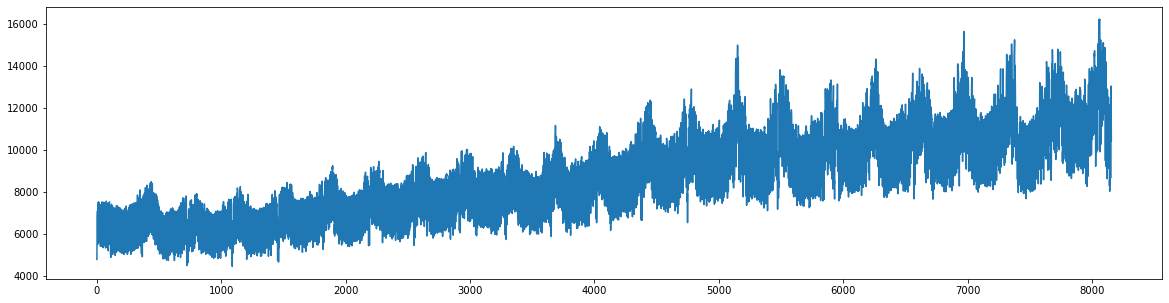

In [9]:
plt.figure(figsize=(20,5))
train.y.plot()
plt.show()

In [10]:
model = fbprophet.Prophet()

In [11]:
model.fit(train) # se houver problema com prophet: conda install -c conda-forge pystan==2.19.1.1

INFO:numexpr.utils:NumExpr defaulting to 6 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
future = create_future(test.index[0], len(test))    # cria dataframe de datas futuras
future.columns = ['ds']
future.head()

,ds
0,2022-05-01
1,2022-05-02
2,2022-05-03
3,2022-05-04
4,2022-05-05


In [13]:
forecast = model.predict(future)

In [14]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head() # yhat = forecast

,ds,yhat,yhat_lower,yhat_upper
0,2022-05-01,9779.973297,8984.552963,10556.060089
1,2022-05-02,12001.221303,11178.642507,12731.381810
2,2022-05-03,12332.062222,11564.005267,13098.550560
3,2022-05-04,12398.660977,11576.818351,13205.102831
4,2022-05-05,12365.090822,11596.689281,13134.935656


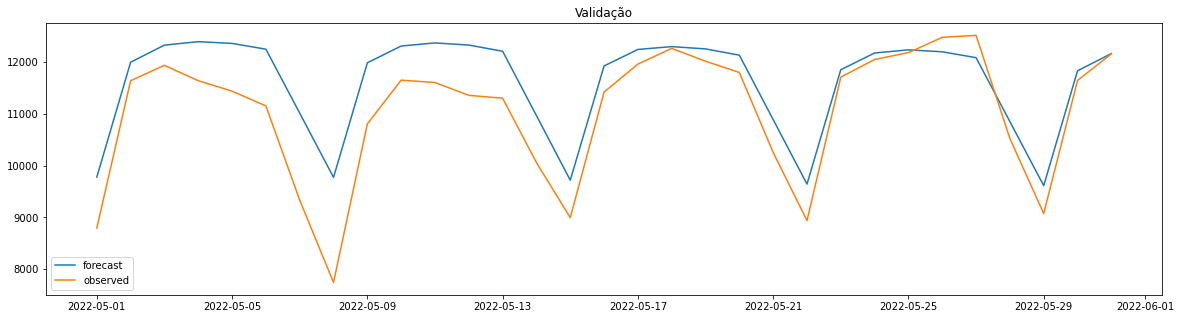

In [15]:
plt.figure(figsize=(20,5))

plt.plot(forecast.ds, forecast.yhat, label = "forecast")    # forecast.ds = data no eixo x; forecast.yhat = forecast no eixo y
plt.plot(test.load_mwmed, label = "observed")   # test já tem data como índice, então não precisa especificar o eixo x

plt.legend()
plt.title("Validação")

plt.show()

In [16]:
# métricas
pd.DataFrame([get_measures(forecast.yhat, test)])

,erro,mae,mse,rmse,mape,smape
0,1.851867e+07,618.522351,597376.371524,772.901269,0.060693,5.768356


In [19]:
fc = pd.DataFrame(list(zip(forecast.ds, forecast.yhat)), columns = ["date", "forecast"])
fc

,date,forecast
0,2022-05-01,9779.973297
1,2022-05-02,12001.221303
2,2022-05-03,12332.062222
3,2022-05-04,12398.660977
4,2022-05-05,12365.090822
5,2022-05-06,12253.258751
6,2022-05-07,11016.483974
7,2022-05-08,9774.013391
8,2022-05-09,11990.110833
9,2022-05-10,12314.741179


### Adicionando feriados

In [44]:
model = fbprophet.Prophet()
model.add_country_holidays(country_name='BR')   # adiciona feriados brasileiros

In [45]:
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [46]:
model.train_holiday_names # verifica os feriados

0                New Year's Day
1                    Tiradentes
2                  Worker's Day
3              Independence Day
4    Our Lady of the Apparition
5                All Souls' Day
6     Republic Proclamation Day
7                     Christmas
dtype: object

In [47]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2022-05-01,8164.595534,7412.595605,8875.932013
1,2022-05-02,12115.609683,11370.034207,12808.164056
2,2022-05-03,12445.234870,11730.989800,13153.063482
3,2022-05-04,12499.634004,11832.555907,13215.112862
4,2022-05-05,12460.468040,11762.038043,13155.245229


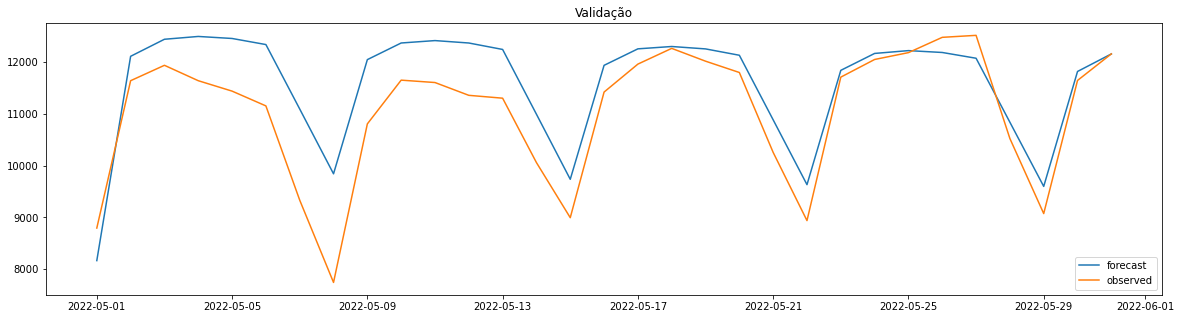

In [48]:
plt.figure(figsize=(20,5))
plt.plot(forecast.ds, forecast.yhat, label = "forecast")
plt.plot(test.load_mwmed, label = "observed")
plt.legend()
plt.title("Validação")

plt.show()

In [49]:
# métricas
pd.DataFrame([get_measures(forecast.yhat, test)])   # piorou

,erro,mae,mse,rmse,mape,smape
0,1.974841e+07,635.96654,637045.329412,798.151195,0.062048,5.906449


### Adicionando mais feriados

In [54]:
# Cria dataframe com feriados brasileiros
import holidays

feriados= holidays.Brazil()
feriados_2 = [x for x in feriados['2000-01-01': '2022-04-30']]
hds = pd.DataFrame({
  'holiday': 'playoff',
  'ds': feriados_2,
  'lower_window': 0,
  'upper_window': 1,
})
hds.head()

,holiday,ds,lower_window,upper_window
0,playoff,2000-01-01,0,1
1,playoff,2000-03-07,0,1
2,playoff,2000-03-08,0,1
3,playoff,2000-04-21,0,1
4,playoff,2000-04-23,0,1


In [56]:
model = fbprophet.Prophet(holidays=hds)
model.add_country_holidays(country_name='BR')   # adiciona feriados brasileiros
model.fit(train)
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


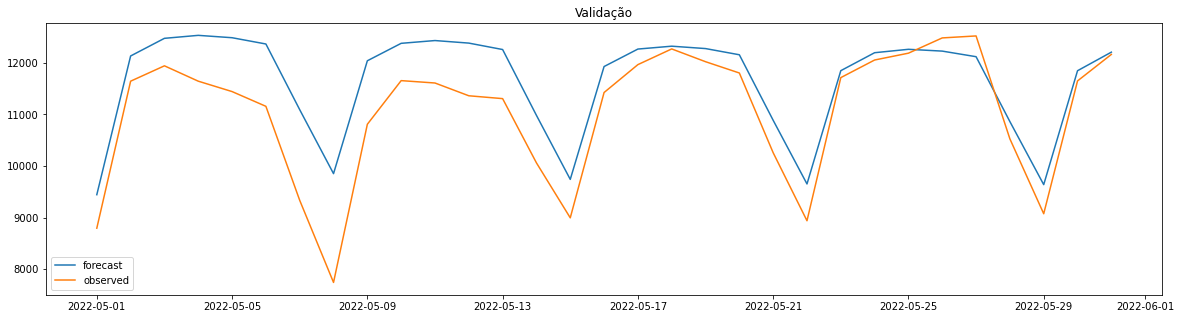

In [59]:
plt.figure(figsize=(20,5))
plt.plot(forecast.ds, forecast.yhat, label = "forecast")
plt.plot(test.load_mwmed, label = "observed")
plt.legend()
plt.title("Validação")

plt.show()

In [60]:
# métricas
pd.DataFrame([get_measures(forecast.yhat, test)])   # piorou

,erro,mae,mse,rmse,mape,smape
0,2.006996e+07,646.824905,647417.945586,804.622859,0.063051,5.984401
